Copyright 2025 Simon P. de Szoeke and Estefanía Quiñones 
Meléndez.

Permission is hereby granted, free of charge, to any person 
obtaining a copy of this software and associated documentation 
files (the “Software”), to deal in the Software without 
restriction, including without limitation the rights to use, 
copy, modify, merge, publish, distribute, sublicense, and/or 
sell copies of the Software, and to permit persons to whom the 
Software is furnished to do so, subject to the following 
conditions:

The above copyright notice and this permission notice shall be 
included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, 
EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES 
OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, 
WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING 
FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR 
OTHER DEALINGS IN THE SOFTWARE.

In [1]:
using Pkg; Pkg.activate(".")
Pkg.instantiate()

using Revise
using PyPlot
using NCDatasets
using Statistics
# using Interpolations

  Activating project at `~/Projects/ATOMIC/ATOMIC-coldpools/release/figure/f02`


In [2]:
# extend PyPlot to mask missing values
using PyCall
using PyCall: PyObject

# extend PyObject to maskedarray to allow for plotting with missing values
function PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

println(PyPlot.matplotlib[:rcParams]["font.sans-serif"])
# Set font to Helvetica or Arial
# rc("font", family="Computer Modern Sans Serif")
rc("font", family="Arial", size=16)

["DejaVu Sans", "Bitstream Vera Sans", "Computer Modern Sans Serif", "Lucida Grande", "Verdana", "Geneva", "Lucid", "Arial", "Helvetica", "Avant Garde", "sans-serif"]


In [3]:
include("VaporSat.jl")
using .VaporSat # for wet-bulb temperature

# constants
Cp = 1005.7  # from my Davies-Jones function, was 1005.
Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

C = 273.15 # K
Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

0.6219718309859156

In [4]:
# functions to integrate the moist adiabat
# down to get the wet-bulb temperature at the reference pressure

# Step 1: get isobaric initial wet bulb temperature
Twet_autodiff(T, q, p) = VaporSat.Twet_autodiff(T, q, p)

"""
chi = dlogT/dlogp exponent for moist adiabatic expansion or compression
uses Bolton's formula for saturation specific humidity qs
"""
chi(T, q, L=VaporSat.LvK(T)) = Rv*T*(Rd*T + L*q) / (Rv*Cp*T^2 + L^2*q)

# Step 2: integrate the moist adiabat down to the reference pressure
"""
    Twet_prof_integrate(Twet, p, p_f; nstep=10)
integrate the moist adiabat down to the reference pressure
Saturated and q=qs by adding or subtracting vapor from an unlimited reservoir
at the same temperature.
"""
function Twet_prof_integrate(T0, p0, p_f; nstep=10)
    # set logp steps
    dlogp = (log(p_f) - log(p0)) / nstep
    pstepfac = exp(dlogp) # factor to multiply p by
    sqrtstepfac = sqrt(pstepfac)
    p = p0 * [1; cumprod(pstepfac .+ zeros(nstep))] # lin space

    "one moist adiabat step"
    function stepT(T0, p0; dlogp=dlogp, sqrtstepfac=sqrtstepfac)
        # half step
        ph = p0 * sqrtstepfac
        logT0 = log(T0)
        logTh = logT0 + chi(T0, VaporSat.qs(p0, T0-273.15)) * dlogp / 2 # log space
        Th = exp(logTh) 

        # full step
        logT1 = logT0 + chi(Th, VaporSat.qs(ph, Th-273.15)) * dlogp
        T1 = exp(logT1)
        return T1
    end

    # initialize temperature
    T = T0 .+ zeros(nstep+1)
    for i in 1:nstep
        # calculate the new temperature
        T[i+1] = stepT(T[i], p[i])
    end
    return T, p
end

"theta_wet(T0, q0, p0, pref=1e5)  wet-bulb potential temperature"
function theta_wet(T0, q0, p0, pref=1e5) 
    Twet_prof_integrate(Twet_autodiff(T0, q0, p0), p0, pref)[1][end]
end


theta_wet

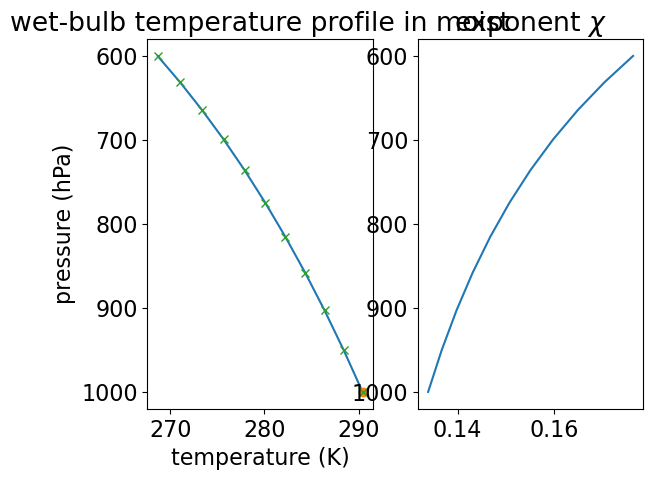

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ari

In [5]:
# test wet-bulb potential temperature
T0 = 270.0 # K
p0 = 6e4 # 6e4 # hPa
q0 = 0.80*VaporSat.qs(p0, T0-273.15) # kg/kg
pref = 1e5 # reference pressure in Pa

T, p = Twet_prof_integrate(Twet_autodiff(T0, q0, p0), p0, pref)

Tf = theta_wet(T0, q0, p0) # 300 K, 0.01 g/kg, 1000 hPa
pf = pref

# integrate back upward, should be reversible
Tup, pup = Twet_prof_integrate(Tf, pf, p0)


clf()
subplot(1,2,1)
plot(T, p/1e2)
gca().invert_yaxis()
plot(Tf, pref/1e2, "o") #, label="wet-bulb potential temperature")
plot(Tup, pup/1e2, "x", label="integrated upward")
xlabel("temperature (K)")
ylabel("pressure (hPa)")
title("wet-bulb temperature profile in moist")

subplot(1,2,2)
plot(chi.(T, VaporSat.qs.(p, T.-273.15)), p/1e2, "-", label=L"\chi")
gca().invert_yaxis()
title("exponent "*L"\chi")
gcf()

# theta = theta_wet(T0, q0, p0)

In [6]:
"specific humidity from mixed ratio"
shum(r) = r/(1+r)

"potential temperature from temperature (K) and pressure (hPa)"
pottmp(T, p) = T * (1000 / p)^(Rd/Cp)

pottmp

In [ ]:
# load data
ds = NCDataset("data/cloud_module_iso_profiles.nc")
# note units
ds["Ta"][1,1]    # Kelvin
ds["press"][1,1] # hPa
ds["mr"][1,1]    # g/kg

# test size
Ta = ds["Ta"][:,:] # 39,16

39×16 Matrix{Union{Missing, Float32}}:
 297.052     297.822     298.226     …  298.929     297.624  298.241
 296.502     298.16      298.143        298.719     297.357  297.34
 295.657     297.084     297.193        297.649     296.484  297.461
 294.551     296.278     296.174        296.536     295.409  297.319
 293.617     294.843     294.933        295.568     294.216  296.04
 292.962     294.532     293.516     …  294.539     293.753  294.669
 292.463     293.53      292.959        293.975     293.384  293.561
 291.36      292.809     292.512        292.643     291.966  293.53
 291.465     292.636     291.867        292.388     291.878  292.342
 290.28      291.965     291.634        291.87      290.413  291.369
   ⋮                                 ⋱                         ⋮
 283.912     283.382        missing  …  282.153     280.104  280.053
    missing     missing     missing        missing  279.72   280.25
    missing     missing     missing        missing  279.158     missing


In [8]:
# compute wet-bulb potential temperature from data
ds["Ta"][:,:], shum.(ds["mr"][:,:]/1e3), 1e2*ds["press"][:,:]
# th = similar(Ta)
function broadcast_theta_wet!(th, T, q, p)
    for i in eachindex(T)
        if !ismissing(T[i]) && !ismissing(q[i]) && !ismissing(p[i])
            th[i] = theta_wet(T[i], q[i], p[i])
        else
            th[i] = missing
        end
    end
    return th
end

thw = similar(ds["Ta"][:,:])
broadcast_theta_wet!(thw, ds["Ta"][:,:], shum.(ds["mr"][:,:]/1e3), 1e2*ds["press"][:,:])

39×16 Matrix{Union{Missing, Float32}}:
 293.589     295.062     295.028     …  294.442     293.727  293.43
 293.625     295.47      295.307        294.556     293.427  293.838
 293.537     295.465     295.473        293.642     293.475  292.897
 293.29      295.395     295.521        294.193     293.527  292.407
 293.222     294.816     295.01         294.314     294.02   292.6
 293.31      294.936     294.744     …  294.082     293.745  293.251
 293.216     294.233     294.579        293.587     293.284  293.187
 293.218     294.437     294.371        293.563     293.031  292.982
 291.93      294.049     294.223        293.62      292.918  292.945
 291.921     293.931     294.051        292.225     292.382  292.561
   ⋮                                 ⋱                         ⋮
 287.551     290.391        missing  …  287.791     286.963  293.129
    missing     missing     missing        missing  287.005  290.969
    missing     missing     missing        missing  287.045     missing

In [17]:
# average profiles by pressure

function binmean(x, y, xq)
    yq = zeros(Float64, size(xq))
    nq = zeros(Int, size(xq))
    for i in eachindex(x)
        if !ismissing(x[i]) && !isnan(x[i]) && !ismissing(y[i]) && !isnan(y[i])
            iq = findlast( xq .<= x[i] )
            yq[iq] += y[i]
            nq[iq] += 1
        end
    end
    return yq./nq
end

# grid by pressure -- not needed, already gridded by height
pbin = 1e3:-10:700 # hPa
pdata = ds["press"][:,:]
th = pottmp.(ds["Ta"][:,:],ds["press"][:,:])
z  = repeat( ds["alt"][:], outer=(1, size(pdata,2)) )
#=
hbin    = binmean(pdata[:], ds["alt"][:,:][:],        pbin)
thbin   = binmean(pdata[:], th[:],                    pbin)
thwbin  = binmeab(pdata[:], thw[:],                   pbin)
qbin    = binmean(pdata[:], shum.(ds["mr"][:,:]/1e3), pbin)
dDbin   = binmean(pdata[:], ds["dD"][:,:][:],         pbin)
d18Obin = binmean(pdata[:], ds["d18O"][:,:][:],       pbin)
=#
thbin   = binmean(z[:], th[  :],                  z[:,1])
thwbin  = binmean(z[:], thw[ :],                  z[:,1])
qbin    = binmean(z[:], shum.(ds["mr"][:,:]/1e3), z[:,1])
dDbin   = binmean(z[:], ds["dD"][:,:][:],         z[:,1])
d18Obin = binmean(z[:], ds["d18O"][:,:][:],       z[:,1])

39-element Vector{Float64}:
 -10.623065757751466
 -10.498219930208647
 -10.51611750466483
 -10.596803733280726
 -10.599112570285797
 -10.650259792804718
 -10.762208044528961
 -10.800432562828064
 -11.038423657417297
 -11.180282533168793
   ⋮
 -25.477893511454266
 -23.448881149291992
 -28.98405933380127
 -23.20393180847168
 -23.552021026611328
 -26.31344223022461
 -26.920713424682617
 -26.372413635253906
 -25.6959171295166

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


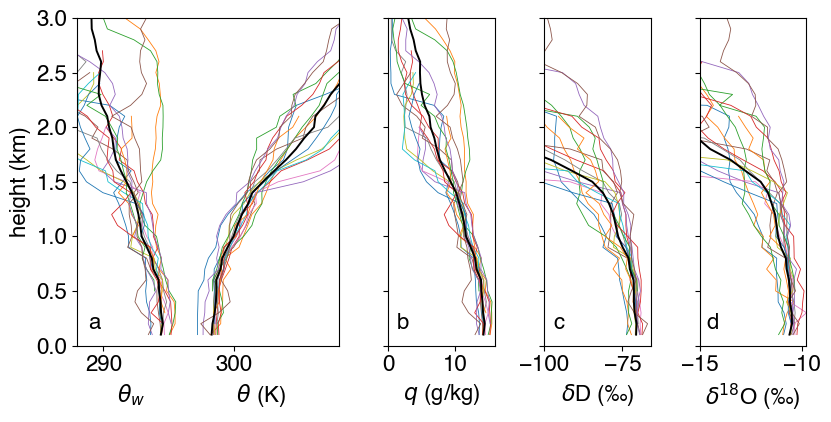

In [ ]:
# plot profiles
fig, axs = subplots(1,6, figsize=(10, 4.5), sharey=true)
i = 1
axs[i].set_visible(false)
axs[i] = subplot(1,3,1)
axs[i].plot(pottmp.(ds["Ta"][:,:],ds["press"][:,:]), ds["alt"][:]/1e3, linewidth=0.6)
axs[i].plot(thbin, z[:,1]/1e3, color="k", linewidth=1.4)
axs[i].set_xlim([297, 310])
axs[i].set_ylim([0, 3])
axs[i].set_xlabel("\$\\theta\$ (K)")
# i = 2
axs[i].set_prop_cycle(matplotlib[:rcParams]["axes.prop_cycle"])  # reset to start of color cycle
axs[i].plot(thw, ds["alt"][:]/1e3, linewidth=0.6)
axs[i].plot(thwbin, z[:,1]/1e3, "k-", linewidth=1.4)
axs[i].set_xlim([288, 296])
axs[i].set_ylim([0, 3])
axs[i].set_xlabel("\$\\theta_w\$ (K)")
# for combined theta and theta_w
axs[i].set_xlim([288, 308])
axs[i].set_xlabel("\$\\theta_w\$ \t\t \$\\theta\$ (K)\t")

i += 1
axs[i].set_visible(false)

i += 1
axs[i].plot(1e3*shum.(ds["mr"][:,:]/1e3), ds["alt"][:]/1e3, linewidth=0.6)
axs[i].plot(1e3*qbin, z[:,1]/1e3, "k-", linewidth=1.4)
axs[i].set_xlim([0, 16])
axs[i].set_ylim([0, 3])
axs[i].set_xlabel("\$q\$ (g/kg)")
minorticks_on(axs[i])

i += 1
axs[i].plot(ds["dD"][:,:], ds["alt"][:]/1e3, linewidth=0.6)
axs[i].plot(dDbin, z[:,1]/1e3, "k-", linewidth=1.4)
axs[i].set_xlim([-100, -66])
axs[i].set_ylim([0, 3])
axs[i].set_xlabel("\$\\delta\$D (‰)")

i += 1
axs[i].plot(ds["d18O"][:,:], ds["alt"][:]/1e3, linewidth=0.6)
axs[i].plot(d18Obin, z[:,1]/1e3, "k-", linewidth=1.4)
axs[i].set_xlim([-15, -9.8])
axs[i].set_ylim([0, 3])
axs[i].set_xlabel("\$\\delta{^{18}}\$O (‰)")

i += 1
axs[i].set_visible(false)

# finish plot
axs[1].set_ylabel("height (km)")
[ax.set_yticklabels([""]) for ax in axs[2:end]]

# align wide left axis
tight_layout()
bbox    = axs[1].get_position()
bbox.x1 = axs[2].get_position().x1
axs[1].set_position(bbox)

axs[1].text(288.8,0.15, "a")
axs[3].text(1.3, 0.15, "b")
axs[4].text(-97, 0.15, "c")
axs[5].text(-14.7, 0.15, "d")

fmt = ["png", "pdf", "svg", "eps"]
[ savefig("P3_profiles.$(f)") for f in fmt ]
gcf()